# Image Classification with Deep Pyramidal Residual Networks
In this application, We are going to implement the Deep Pyramidal Residual Network Proposed [here](https://arxiv.org/abs/1610.02915) in TensorFlow.

The core idea of the paper is that building the network with number of feature channels increased by predefined linear function, combining with residual connection can help with learning process.

## Import the required libraries

In [1]:
import tempfile

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

import fastestimator as fe
from fastestimator.dataset.data.cifair10 import load_data
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, PadIfNeeded, RandomCrop
from fastestimator.op.numpyop.univariate import CoarseDropout, Normalize
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy
from fastestimator.util import get_num_devices

In [2]:
#training parameters
epochs = 150
batch_size = 32
max_train_steps_per_epoch = None
max_eval_steps_per_epoch = None
save_dir = tempfile.mkdtemp()

## Dataset Loading

In this application, we apply the network on the ciFAIR10 dataset.

In [3]:
train_data, eval_data = load_data()

## Preprocessing
The image pixel values are first normalized by predefined constant, then we apply random padding and cropping, followed by horizontal flip and cut out during training. 

In [4]:
pipeline = fe.Pipeline(
    train_data=train_data,
    eval_data=eval_data,
    batch_size=batch_size * get_num_devices(),
    ops=[
        Normalize(inputs="x", outputs="x", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
        PadIfNeeded(min_height=40, min_width=40, image_in="x", image_out="x", mode="train"),
        RandomCrop(32, 32, image_in="x", image_out="x", mode="train"),
        Sometimes(HorizontalFlip(image_in="x", image_out="x", mode="train")),
        CoarseDropout(inputs="x", outputs="x", mode="train", max_holes=1)
    ])

## Visualize Preprocessing Results

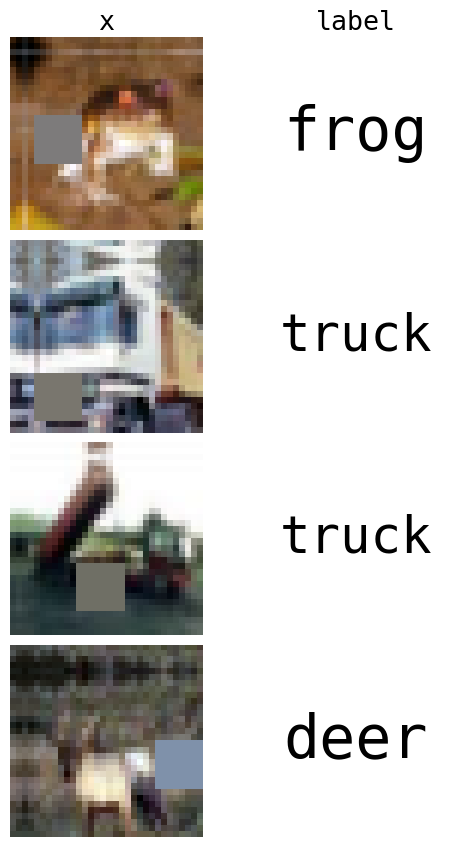

In [5]:
from matplotlib import pyplot as plt
import numpy as np
images_to_display = min(4, batch_size)
data = pipeline.get_results()
class_dictionary = {
    0: "airplane", 1: "car", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"
}
y = np.array([class_dictionary[clazz.item()] for clazz in fe.util.to_number(data["y"])])
images = fe.util.ImgData(x=data["x"].numpy()[0:images_to_display], label=y[0:images_to_display])
fig = images.paint_figure()
plt.show()

## Define Pyramidal Network

In [6]:
def basic_block(x, planes, stride=1, downsample=False):
    out = layers.BatchNormalization()(x)
    out = layers.Conv2D(filters=planes, kernel_size=3, strides=stride, padding="same", use_bias=False)(out)
    out = layers.BatchNormalization()(out)
    out = layers.ReLU()(out)
    out = layers.Conv2D(filters=planes, kernel_size=3, padding="same", use_bias=False)(out)
    out = layers.BatchNormalization()(out)
    shortcut = x
    if downsample:
        shortcut = layers.AveragePooling2D()(shortcut)
    if shortcut.shape[-1] != out.shape[-1]:
        shortcut = tf.pad(shortcut, [[0, 0], [0, 0], [0, 0], [0, out.shape[-1] - shortcut.shape[-1]]])
    return out + shortcut


def bottle_neck(x, planes, stride=1, downsample=False):
    out = layers.BatchNormalization()(x)
    out = layers.Conv2D(filters=planes, kernel_size=1, padding="same", use_bias=False)(out)
    out = layers.BatchNormalization()(out)
    out = layers.ReLU()(out)
    out = layers.Conv2D(filters=planes, kernel_size=3, strides=stride, padding="same", use_bias=False)(out)
    out = layers.BatchNormalization()(out)
    out = layers.ReLU()(out)
    out = layers.Conv2D(filters=planes * 4, kernel_size=1, padding="same", use_bias=False)(out)
    out = layers.BatchNormalization()(out)
    shortcut = x
    if downsample:
        shortcut = layers.AveragePooling2D()(shortcut)
    if shortcut.shape[-1] != out.shape[-1]:
        shortcut = tf.pad(shortcut, [[0, 0], [0, 0], [0, 0], [0, out.shape[-1] - shortcut.shape[-1]]])
    return out + shortcut


def make_group(x, featuremap_dim, addrate, block, block_depth, stride=1):
    for i in range(0, block_depth):
        featuremap_dim += addrate
        if i == 0:
            x = block(x=x, planes=int(round(featuremap_dim)), stride=stride, downsample=stride != 1)
        else:
            x = block(x=x, planes=int(round(featuremap_dim)), stride=1)
    return x, featuremap_dim


def pyramidnet_cifar(inputs_shape, depth, alpha, num_classes, bottleneck=False):
    if bottleneck:
        n = int((depth - 2) / 9)
        block = bottle_neck
    else:
        n = int((depth - 2) / 6)
        block = basic_block
    addrate = alpha / 3 / n
    inputs = layers.Input(shape=inputs_shape)
    x = layers.Conv2D(filters=16, kernel_size=3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x, featuremap_dim = make_group(x, 16, addrate=addrate, block=block, block_depth=n)
    x, featuremap_dim = make_group(x, featuremap_dim, addrate=addrate, block=block, block_depth=n, stride=2)
    x, featuremap_dim = make_group(x, featuremap_dim, addrate=addrate, block=block, block_depth=n, stride=2)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.AveragePooling2D(8)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(num_classes)(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

## Create instance of the model and put it in `Network`

In [7]:
model = fe.build(
    model_fn=lambda: pyramidnet_cifar(inputs_shape=(32, 32, 3), depth=272, alpha=200, num_classes=10, bottleneck=True),
    optimizer_fn=lambda: tfa.optimizers.SGDW(weight_decay=0.0001, lr=0.1, momentum=0.9))

network = fe.Network(ops=[
    ModelOp(model=model, inputs="x", outputs="y_pred"),
    CrossEntropy(inputs=("y_pred", "y"), outputs="ce", from_logits=True),
    UpdateOp(model=model, loss_name="ce")
])

## Define traces and `Estimator`
We schedule the learning rate based on epochs, and calculate accuracy to save the best model we have seen during evaluation.

In [8]:
def lr_schedule(epoch):
    if epoch < 75:
        lr = 0.1
    elif epoch < 110:
        lr = 0.01
    else:
        lr = 0.001
    return lr

traces = [
    Accuracy(true_key="y", pred_key="y_pred"),
    LRScheduler(model=model, lr_fn=lr_schedule),
    BestModelSaver(model=model, save_dir=save_dir, metric="accuracy", save_best_mode="max")]

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=epochs,
                         traces=traces,
                         max_train_steps_per_epoch=max_train_steps_per_epoch,
                         max_eval_steps_per_epoch=max_eval_steps_per_epoch)

## Train the model
The training takes ~18 hours using single V100 GPU, the best evaluation accuracy is ~ 96.5%.

Here are the accuracy from 5 independent runs for reference: 0.9661, 0.9636, 0.9646, 0.9625, 0.9655

In [ ]:
estimator.fit()